In [70]:
!pip install lime

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Sklearn ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # Added for XAI proxy model
from sklearn.metrics import roc_auc_score, classification_report # Added for XAI model eval
from scipy.stats import ks_2samp

# --- TensorFlow / Keras ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import lime
import lime.lime_tabular


In [72]:
# --- Settings ---
warnings.filterwarnings('ignore', category=FutureWarning) # Suppress seaborn FutureWarnings
pd.set_option('display.max_columns', None) # Show all columns in dataframes

In [74]:
# --- Settings ---
warnings.filterwarnings('ignore', category=FutureWarning) # Suppress seaborn FutureWarnings
pd.set_option('display.max_columns', None) # Show all columns in dataframes

In [75]:
data_path = '/kaggle/input/crop-and-soil-dataset/data_core.csv'

In [76]:
numerical_features = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
categorical_features = ['Soil Type', 'Crop Type', 'Fertilizer Name']
target_for_xai = 'Fertilizer Name' # Define the target for the proxy XAI model

In [77]:
# --- VAE/CVAE Parameters ---
latent_dim = 10
intermediate_dim_encoder = 128
intermediate_dim_decoder = 128
batch_size = 64
epochs = 50 # Reduced epochs for faster demonstration, increase if needed
beta = 1.0 # Beta factor for KL loss (β-VAE). beta=1.0 is standard VAE.
validation_split_ratio = 0.1

In [78]:
# --- Evaluation Parameters ---
n_samples_to_generate = 1000
clip_negatives = True

In [79]:
# --- Load the dataset ---
try:
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {data_path}")
    print("Please ensure the file path is correct and the data is added to your Kaggle notebook or runtime.")
    # Optional: Stop execution or raise error if file not found
    raise FileNotFoundError(f"Dataset file not found at {data_path}")

Dataset loaded successfully.
Shape: (8000, 9)


In [80]:
# --- Basic EDA (Keep your existing EDA cells here) ---
print("\n--- Dataset Info ---")
df.info()

print("\n--- Basic Statistics (Numerical Features) ---")
print(df[numerical_features].describe())

print("\n--- Missing Values ---")
print(df.isnull().sum()) # No missing values found previously, good to re-confirm

print("\n--- Value Counts (Categorical Features) ---")
for col in categorical_features:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temparature      8000 non-null   float64
 1   Humidity         8000 non-null   float64
 2   Moisture         8000 non-null   float64
 3   Soil Type        8000 non-null   object 
 4   Crop Type        8000 non-null   object 
 5   Nitrogen         8000 non-null   int64  
 6   Potassium        8000 non-null   int64  
 7   Phosphorous      8000 non-null   int64  
 8   Fertilizer Name  8000 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 562.6+ KB

--- Basic Statistics (Numerical Features) ---
       Temparature     Humidity     Moisture     Nitrogen    Potassium  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean     30.338895    59.210731    43.580863    18.429125     3.916375   
std       4.478262     8.177366  

In [81]:
print("\n--- Running EDA Visualizations (plots omitted in this text output) ---")


--- Running EDA Visualizations (plots omitted in this text output) ---



--- Visualizing Numerical Feature Distributions ---


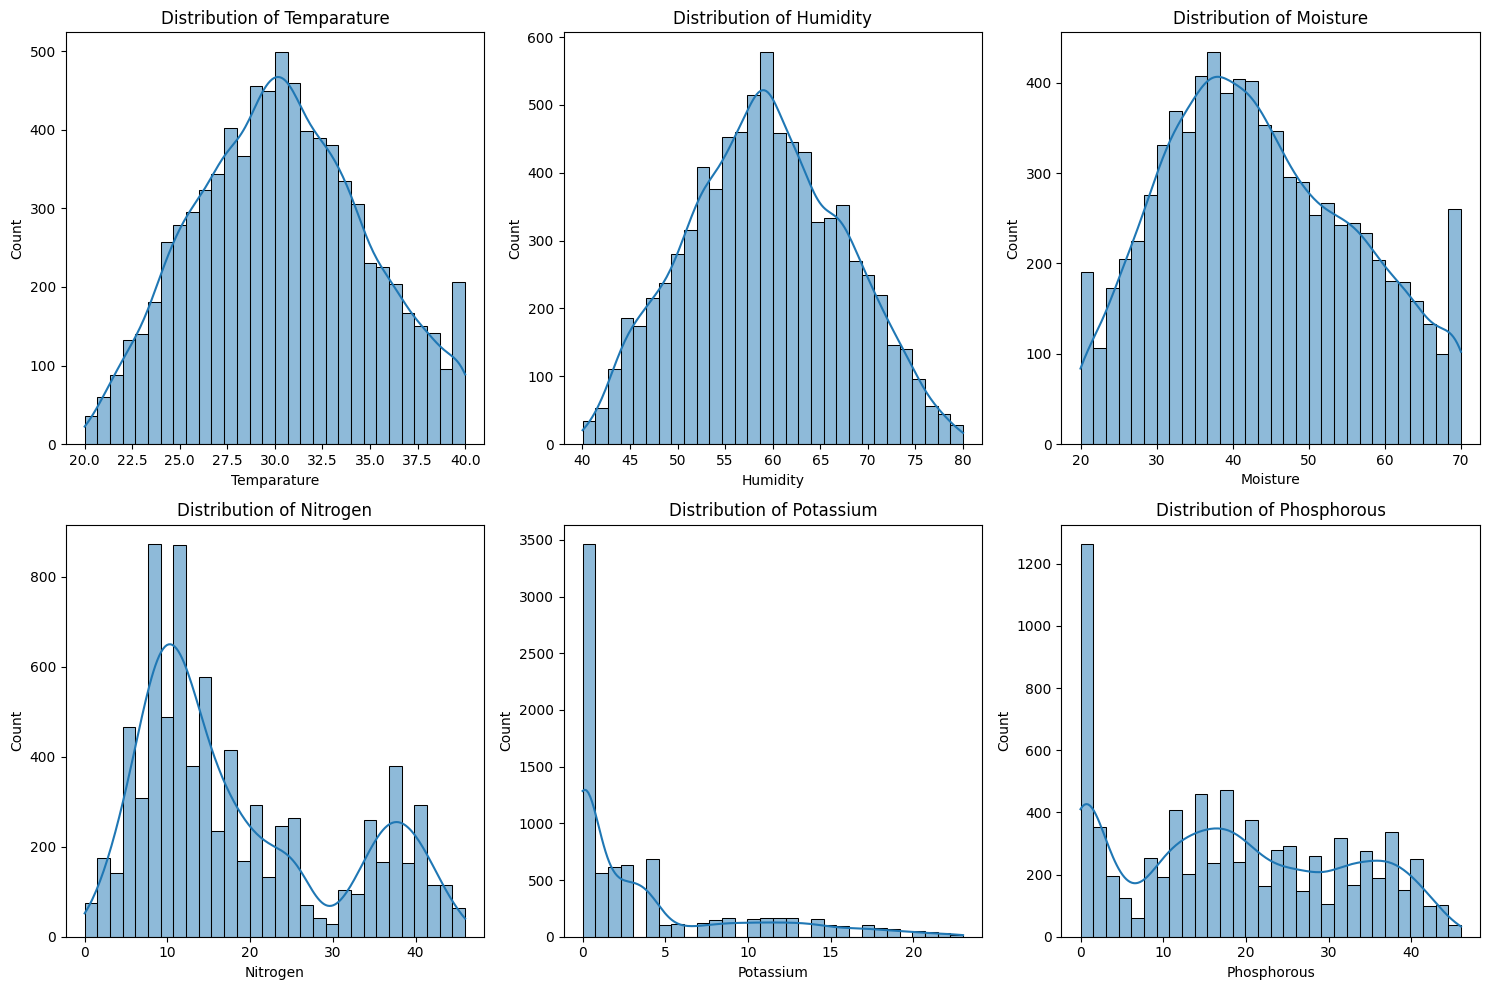

In [82]:
# Visualize Distributions (Histograms/KDE)
print("\n--- Visualizing Numerical Feature Distributions ---")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30) # Increased bins
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


--- Visualizing Numerical Feature Outliers (Box Plots) ---


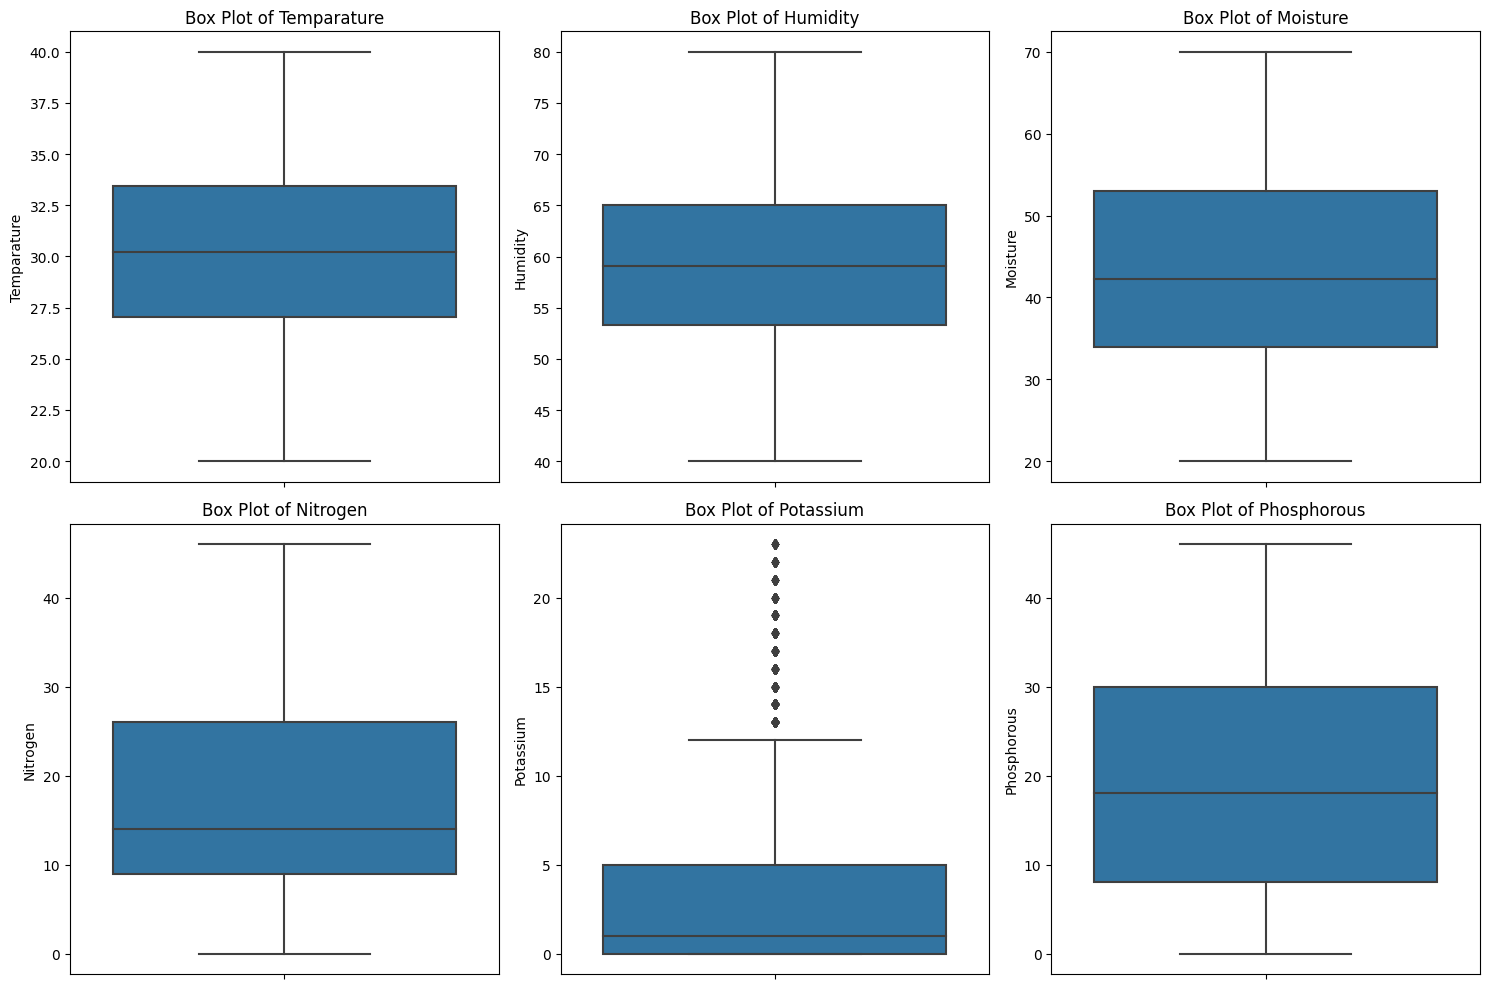

In [83]:
# Visualize Outliers (Box Plots) - NEW
print("\n--- Visualizing Numerical Feature Outliers (Box Plots) ---")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


--- Visualizing Categorical Features ---


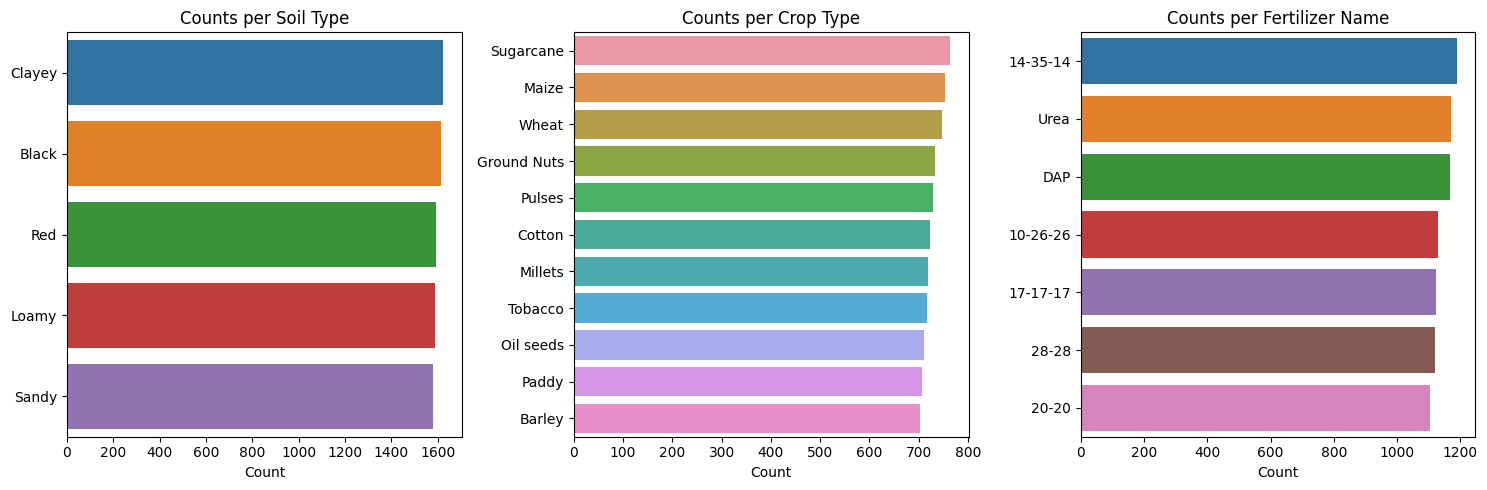

In [84]:
# Visualize Categorical Features
print("\n--- Visualizing Categorical Features ---")
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_features):
    plt.subplot(1, 3, i + 1)
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f'Counts per {col}')
    plt.xlabel('Count')
    plt.ylabel('') # Remove y-label for clarity
plt.tight_layout()
plt.show()


--- Correlation Matrix (Numerical Features) ---


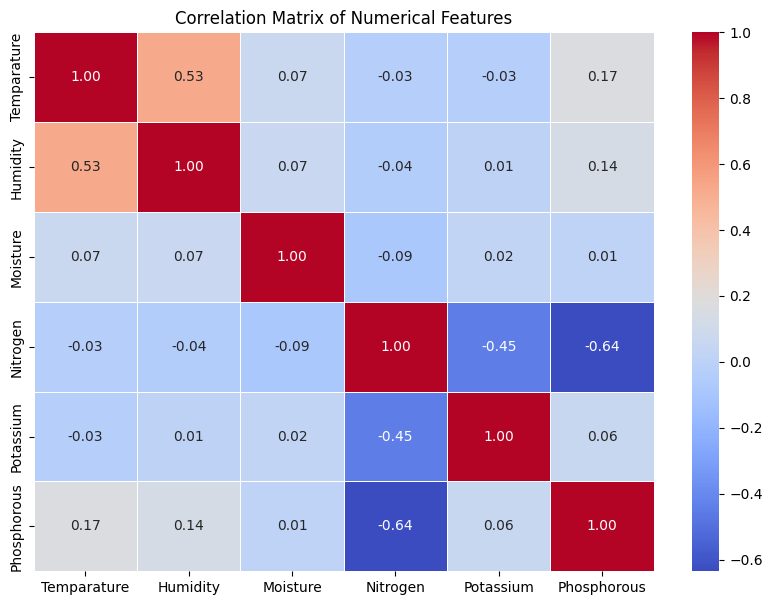

In [85]:
# Correlation Heatmap (Numerical Features)
print("\n--- Correlation Matrix (Numerical Features) ---")
plt.figure(figsize=(10, 7))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # Added linewidths
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [86]:
print("\n--- Preprocessing Data ---")


--- Preprocessing Data ---


In [87]:
# Separate features and target (target is only needed for XAI proxy model)
X = df.drop(target_for_xai, axis=1)
y = df[target_for_xai] # Target for XAI classifier

In [88]:
# Identify numerical and categorical features *for X*
numerical_features_X = [col for col in numerical_features if col in X.columns]
categorical_features_X = [col for col in categorical_features if col in X.columns] # Soil Type, Crop Type

In [89]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False for easier handling later
])

In [90]:
# Create a column transformer to apply different transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_X),
        ('cat', categorical_transformer, categorical_features_X)
    ],
    remainder='passthrough' # Keep other columns if any (shouldn't be any here)
)

In [91]:
# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

In [92]:
# Get feature names after OneHotEncoding
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features_X)
processed_feature_names = numerical_features_X + list(ohe_feature_names)

In [93]:
# Convert processed data back to DataFrame (optional, for inspection)
X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)
print("Processed Data Sample (Features for CVAE/XAI):")
print(X_processed_df.head())
print(f"Processed Data Shape: {X_processed.shape}")

Processed Data Sample (Features for CVAE/XAI):
   Temparature  Humidity  Moisture  Nitrogen  Potassium  Phosphorous  \
0    -0.968940 -0.881847 -0.443088  1.566942  -0.712786    -1.397878   
1    -0.298995 -0.881847  0.112671 -0.542466  -0.712786     1.320481   
2     0.817579  0.708007  1.462374 -0.964348   0.925227     0.867421   
3     0.370949  0.341118 -0.760666  0.301297  -0.712786     0.112321   
4    -0.522310 -0.637254  0.192066  1.398190  -0.712786    -1.397878   

   Soil Type_Black  Soil Type_Clayey  Soil Type_Loamy  Soil Type_Red  \
0              0.0               0.0              0.0            0.0   
1              0.0               0.0              1.0            0.0   
2              1.0               0.0              0.0            0.0   
3              0.0               0.0              0.0            1.0   
4              0.0               1.0              0.0            0.0   

   Soil Type_Sandy  Crop Type_Barley  Crop Type_Cotton  Crop Type_Ground Nuts  \
0     

In [94]:
# Convert target 'Fertilizer Name' to one-hot encoded format for CVAE conditioning
fertilizer_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_one_hot = fertilizer_ohe.fit_transform(y.values.reshape(-1, 1))
fertilizer_classes = fertilizer_ohe.categories_[0] # Get class names
num_fertilizer_classes = y_one_hot.shape[1]
print(f"Number of fertilizer classes (for CVAE condition): {num_fertilizer_classes}")


Number of fertilizer classes (for CVAE condition): 7


In [95]:
# We need to separate the numerical part from X_processed and combine OHE Soil/Crop with OHE Fertilizer

num_numerical_features = len(numerical_features_X)
X_numerical_processed = X_processed[:, :num_numerical_features]

In [96]:
# Conditions are OHE Soil Type + OHE Crop Type (from X_processed) + OHE Fertilizer Name (from y_one_hot)
X_categorical_processed = X_processed[:, num_numerical_features:]
all_conditions_processed = np.hstack((X_categorical_processed, y_one_hot))

print(f"Shape of numerical data for CVAE input: {X_numerical_processed.shape}")
print(f"Shape of condition data for CVAE: {all_conditions_processed.shape}")

Shape of numerical data for CVAE input: (8000, 6)
Shape of condition data for CVAE: (8000, 23)


In [97]:
# Convert data to float32 for TensorFlow
X_numerical_processed = X_numerical_processed.astype(np.float32)
all_conditions_processed = all_conditions_processed.astype(np.float32)

In [98]:
# --- Split Data for CVAE Training and Validation ---
# We split based on the original indices before processing
indices = np.arange(X_numerical_processed.shape[0])
train_indices, val_indices = train_test_split(indices, test_size=validation_split_ratio, random_state=42, stratify=y) # Stratify by fertilizer

In [99]:
X_train_num = X_numerical_processed[train_indices]
X_val_num = X_numerical_processed[val_indices]
cond_train = all_conditions_processed[train_indices]
cond_val = all_conditions_processed[val_indices]

print(f"\nCVAE Training numerical samples: {X_train_num.shape[0]}")
print(f"CVAE Validation numerical samples: {X_val_num.shape[0]}")
print(f"CVAE Training condition samples: {cond_train.shape[0]}")
print(f"CVAE Validation condition samples: {cond_val.shape[0]}")


CVAE Training numerical samples: 7200
CVAE Validation numerical samples: 800
CVAE Training condition samples: 7200
CVAE Validation condition samples: 800


In [100]:
# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_num, cond_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_num, cond_val)).batch(batch_size)

In [103]:
# --- CVAE Model Definition ---
original_dim = X_train_num.shape[1] # Dimension of numerical features
condition_dim = cond_train.shape[1] # Dimension of combined one-hot encoded conditions

In [104]:
# Encoder
encoder_inputs_num = keras.Input(shape=(original_dim,), name='encoder_input_numerical')
encoder_inputs_cond = keras.Input(shape=(condition_dim,), name='encoder_input_condition')
encoder_inputs_combined = layers.concatenate([encoder_inputs_num, encoder_inputs_cond], name='encoder_combined_input')

h = layers.Dense(intermediate_dim_encoder, activation="relu")(encoder_inputs_combined)
h = layers.BatchNormalization()(h)
h = layers.Dense(intermediate_dim_encoder // 2, activation="relu")(h)
z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

In [105]:
# Sampling function (reparameterization trick) - same as before
def sampling(args):
    z_mean_layer, z_log_var_layer = args
    batch = tf.shape(z_mean_layer)[0]
    dim = tf.shape(z_mean_layer)[1]
    epsilon = tf.random.normal(shape=(batch, dim), mean=0.0, stddev=1.0)
    return z_mean_layer + tf.exp(0.5 * z_log_var_layer) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
encoder = keras.Model([encoder_inputs_num, encoder_inputs_cond], [z_mean, z_log_var, z], name="encoder")
print("\n--- Encoder Summary ---")
encoder.summary()


--- Encoder Summary ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_numerical   │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_input_condition   │ (None, 23)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_combined_input    │ (None, 29)             │              0 │ encoder_input_numeric… │
│ (Concatenate)             │                        │                │ encoder_input_conditi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │          3,840 │ encoder_combined_inpu… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │            650 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │            650 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,908 (54.33 KB)

 Trainable params: 13,652 (53.33 KB)

 Non-trainable params: 256 (1.00 KB)

In [106]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="decoder_input_latent")
decoder_inputs_cond = keras.Input(shape=(condition_dim,), name='decoder_input_condition')
decoder_inputs_combined = layers.concatenate([latent_inputs, decoder_inputs_cond], name='decoder_combined_input')

h = layers.Dense(intermediate_dim_decoder // 2, activation="relu")(decoder_inputs_combined)
h = layers.BatchNormalization()(h)
h = layers.Dense(intermediate_dim_decoder, activation="relu")(h)
decoder_outputs = layers.Dense(original_dim, activation="linear", name="decoder_output")(h) # Linear activation for reconstruction
decoder = keras.Model([latent_inputs, decoder_inputs_cond], decoder_outputs, name="decoder")
print("\n--- Decoder Summary ---")
decoder.summary()


--- Decoder Summary ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_input_latent      │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input_condition   │ (None, 23)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_combined_input    │ (None, 33)             │              0 │ decoder_input_latent[… │
│ (Concatenate)             │                        │                │ decoder_input_conditi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          2,176 │ decoder_combined_inpu… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64)             │            256 │ dense_8[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │          8,320 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_output (Dense)    │ (None, 6)              │            774 │ dense_9[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,526 (45.02 KB)

 Trainable params: 11,398 (44.52 KB)

 Non-trainable params: 128 (512.00 B)

In [107]:
# --- CVAE Model Class ---
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, beta_val, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta_val
        self.mse_loss_fn = tf.keras.losses.MeanSquaredError() # Use built-in MSE
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x_num, condition = data # Data comes as a tuple from tf.data.Dataset
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([x_num, condition], training=True)
            reconstruction = self.decoder([z, condition], training=True)

            # --- Loss Calculation ---
            # Reconstruction Loss: Compare original numerical input (x_num) with reconstruction
            # Use tf.reduce_mean directly on the MSE loss instance output (already averaged over features)
            reconstruction_loss = self.mse_loss_fn(x_num, reconstruction)
            # Scale reconstruction loss by original dim (common practice, scales it similarly to KL loss)
            reconstruction_loss *= original_dim

            # KL Loss: Calculated per sample, summed over latent dims, then averaged over batch
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total Loss
            total_loss = reconstruction_loss + self.beta * kl_loss
            # --- End Loss Calculation ---

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x_num, condition = data
        z_mean, z_log_var, z = self.encoder([x_num, condition], training=False)
        reconstruction = self.decoder([z, condition], training=False)

        # --- Loss Calculation (Consistent with train_step) ---
        reconstruction_loss = self.mse_loss_fn(x_num, reconstruction)
        reconstruction_loss *= original_dim
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + self.beta * kl_loss
        # --- End Loss Calculation ---

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}


In [108]:
# Instantiate the CVAE model
cvae = CVAE(encoder, decoder, beta_val=beta)

In [109]:
# Compile and Train
cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
print("\n--- Training CVAE ---")


--- Training CVAE ---


In [110]:
# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_total_loss', # Monitor total validation loss
                                             patience=10,
                                             restore_best_weights=True,mode='min')

history = cvae.fit(train_dataset,
                   epochs=epochs,
                   validation_data=val_dataset,
                   callbacks=[early_stopping],
                   verbose=1)


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - kl_loss: 4.1722 - reconstruction_loss: 6.1401 - total_loss: 10.3123 - val_kl_loss: 0.2839 - val_reconstruction_loss: 5.6051 - val_total_loss: 5.8890
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.8630 - reconstruction_loss: 3.9926 - total_loss: 5.8555 - val_kl_loss: 0.6653 - val_reconstruction_loss: 4.8341 - val_total_loss: 5.4994
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.8501 - reconstruction_loss: 3.6289 - total_loss: 5.4790 - val_kl_loss: 1.1946 - val_reconstruction_loss: 3.9329 - val_total_loss: 5.1275
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.8969 - reconstruction_loss: 3.2739 - total_loss: 5.1708 - val_kl_loss: 1.7225 - val_reconstruction_loss: 3.1482 - val_total_loss: 4.8707
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.9273 - reconstruction_loss: 3.0541 - total_loss: 4.9814 - val_kl_loss: 1.8787 - val_reconstruction_loss: 2.8529 - val_total_l

In [111]:
print("\n--- Plotting CVAE Training History (plots omitted in text output) ---")


--- Plotting CVAE Training History (plots omitted in text output) ---


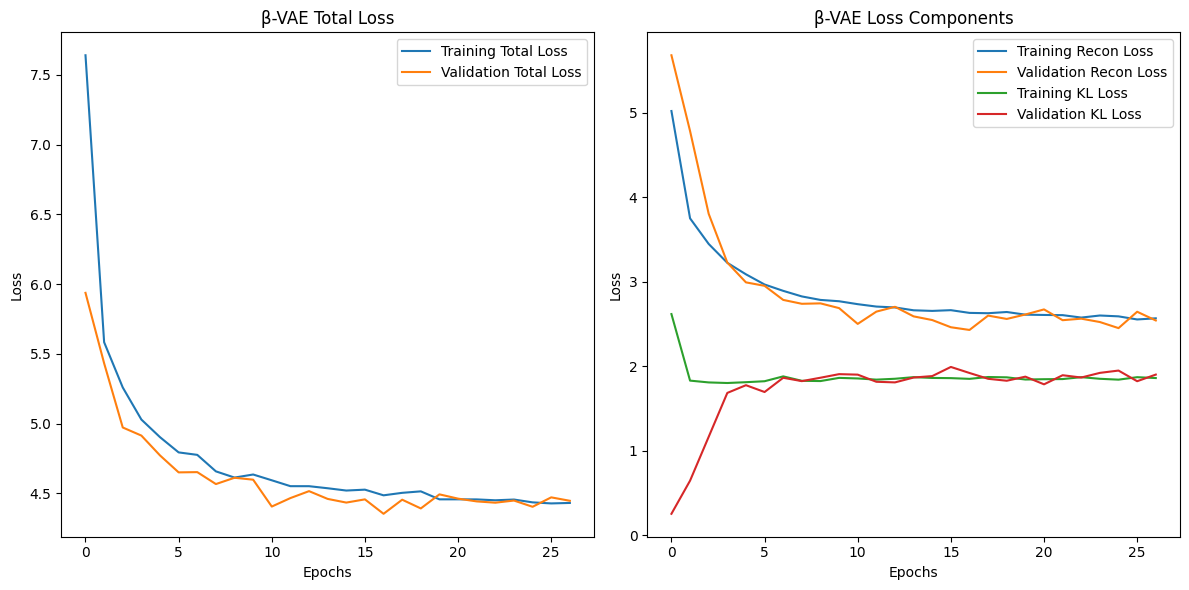

In [40]:
# Plot training vs validation total loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['total_loss'],       label='Training Total Loss')
plt.plot(history.history['val_total_loss'],   label='Validation Total Loss')
plt.title('β-VAE Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the individual components
plt.subplot(1, 2, 2)
plt.plot(history.history['reconstruction_loss'],       label='Training Recon Loss')
plt.plot(history.history['val_reconstruction_loss'],   label='Validation Recon Loss')
plt.plot(history.history['kl_loss'],                   label='Training KL Loss')
plt.plot(history.history['val_kl_loss'],               label='Validation KL Loss')
plt.title('β-VAE Loss Components')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [112]:
# --- CVAE Evaluation: Generate Conditional Synthetic Data ---
print(f"\n--- Generating {n_samples_to_generate} Conditional Synthetic Samples ---")


--- Generating 1000 Conditional Synthetic Samples ---


In [113]:
# Sample random indices from the training condition set
sample_indices = np.random.choice(cond_train.shape[0], n_samples_to_generate, replace=True)
sampled_conditions = cond_train[sample_indices]

In [114]:
# Sample random points from the standard normal distribution (latent space)
random_latent_vectors = np.random.normal(size=(n_samples_to_generate, latent_dim)).astype(np.float32)

In [115]:
# Decode using the CVAE decoder with sampled latent vectors and conditions
synthetic_data_scaled = cvae.decoder.predict([random_latent_vectors, sampled_conditions])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [116]:
# Inverse transform the generated numerical data to the original scale
# Access the 'scaler' step from the numerical transformer within the preprocessor
scaler_step = preprocessor.named_transformers_['num']['scaler']
synthetic_data_numerical = scaler_step.inverse_transform(synthetic_data_scaled)

In [117]:
# Convert generated numerical data to DataFrame
df_synthetic_numerical = pd.DataFrame(synthetic_data_numerical, columns=numerical_features_X)

In [118]:
# Clip negative values if necessary (e.g., for N, P, K)
if clip_negatives:
    print("\n--- Clipping potential negative values in generated numerical data ---")
    # Adjust columns as needed (Temperature/Humidity usually don't need clipping)
    cols_to_clip = ['Nitrogen', 'Potassium', 'Phosphorous', 'Moisture', 'Humidity']
    for col in cols_to_clip:
        if col in df_synthetic_numerical.columns:
            # Check if column exists before clipping
            df_synthetic_numerical[col] = df_synthetic_numerical[col].clip(lower=0)


print("\n--- Generated Synthetic Numerical Data (Original Scale, potentially clipped) ---")
print(df_synthetic_numerical.head())

print("\n--- Basic Statistics (Generated Synthetic Numerical Data) ---")
print(df_synthetic_numerical.describe())


--- Clipping potential negative values in generated numerical data ---

--- Generated Synthetic Numerical Data (Original Scale, potentially clipped) ---
   Temparature   Humidity   Moisture   Nitrogen  Potassium  Phosphorous
0    34.780266  66.080154  48.813919  33.037235   1.022188     7.151724
1    28.281284  52.886627  57.779499   7.747339   8.802363    30.823259
2    32.665241  63.373306  56.229458   9.902046   7.083461    26.452841
3    34.697262  69.286407  52.689705  34.820045   1.580769     5.554509
4    32.362137  62.090427  50.786285  18.975500   0.260534    22.273687

--- Basic Statistics (Generated Synthetic Numerical Data) ---
       Temparature     Humidity     Moisture     Nitrogen    Potassium  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     30.132324    58.640266    43.401039    18.699301     4.039336   
std       3.145893     5.631279     9.357674     9.218218     4.300880   
min      22.084814    44.232822    20.475170     4.8190

In [48]:
# --- Compare Distributions (Real vs. Synthetic Numerical Features) ---
print("\n--- Comparing Distributions (Real vs. Synthetic Numerical) ---")


--- Comparing Distributions (Real vs. Synthetic Numerical) ---


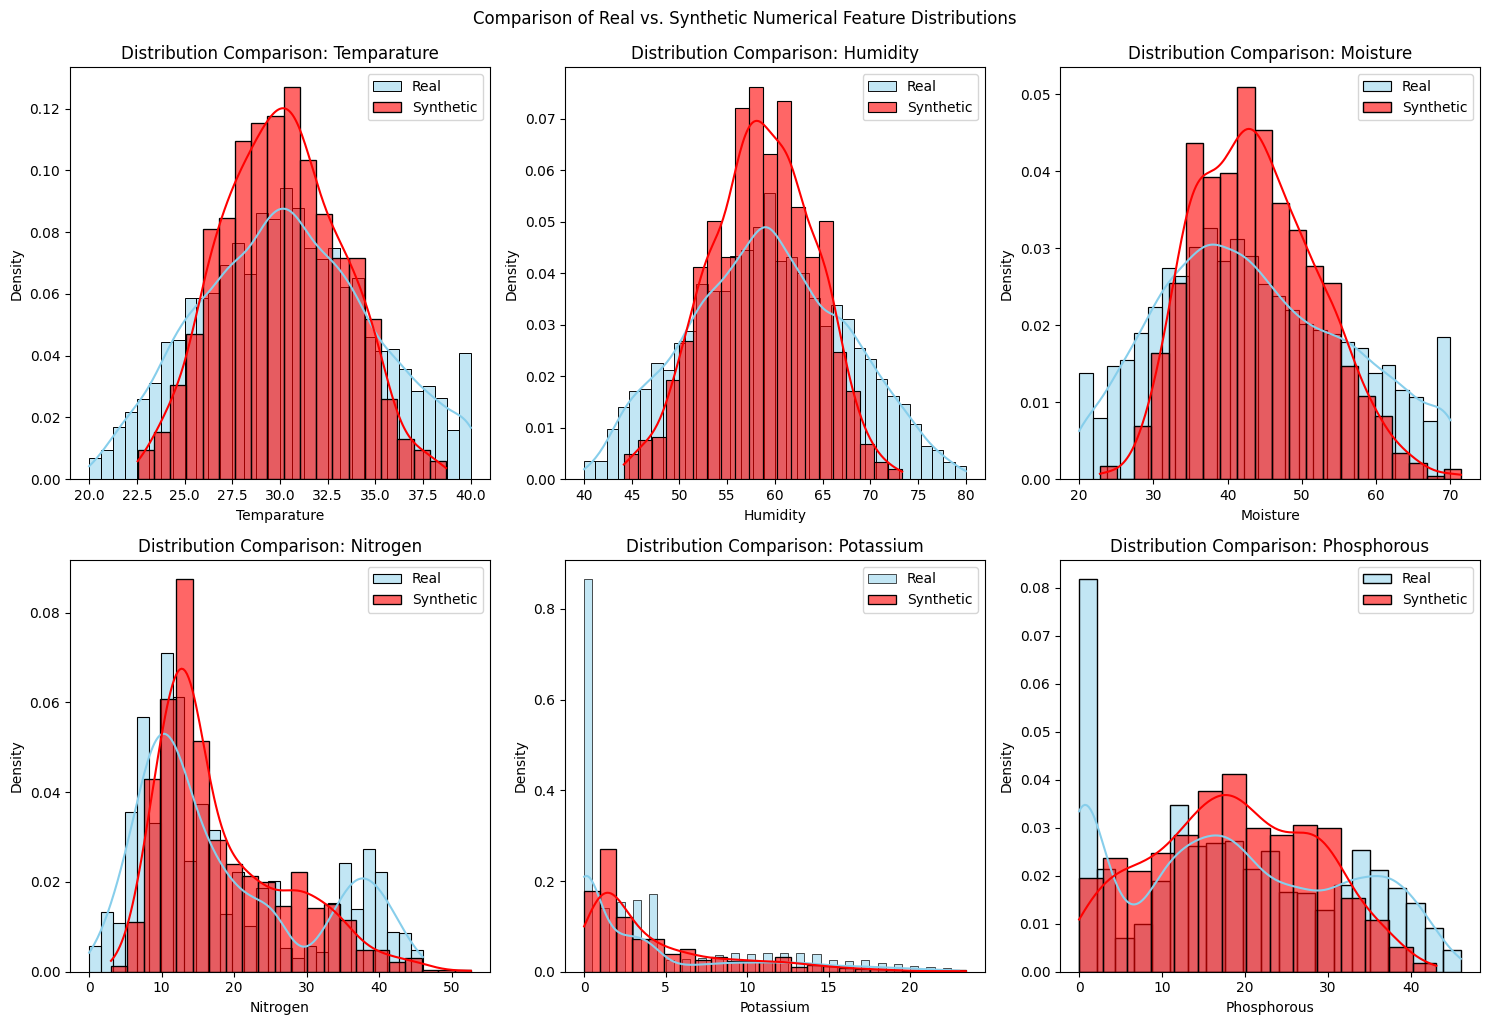

In [49]:
# Get the original numerical data for comparison
df_real_numerical = df[numerical_features_X]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features_X):
    plt.subplot(2, 3, i + 1) # Adjust grid if more/fewer numerical features
    sns.histplot(df_real_numerical[col].dropna(), color='skyblue', label='Real', kde=True, stat="density", common_norm=False)
    sns.histplot(df_synthetic_numerical[col], color='red', label='Synthetic', kde=True, stat="density", common_norm=False, alpha=0.6)
    plt.title(f'Distribution Comparison: {col}')
    plt.legend()
plt.tight_layout()
plt.suptitle("Comparison of Real vs. Synthetic Numerical Feature Distributions", y=1.02)
plt.show()


--- Comparing Correlation Matrices (Real vs. Synthetic Numerical) ---


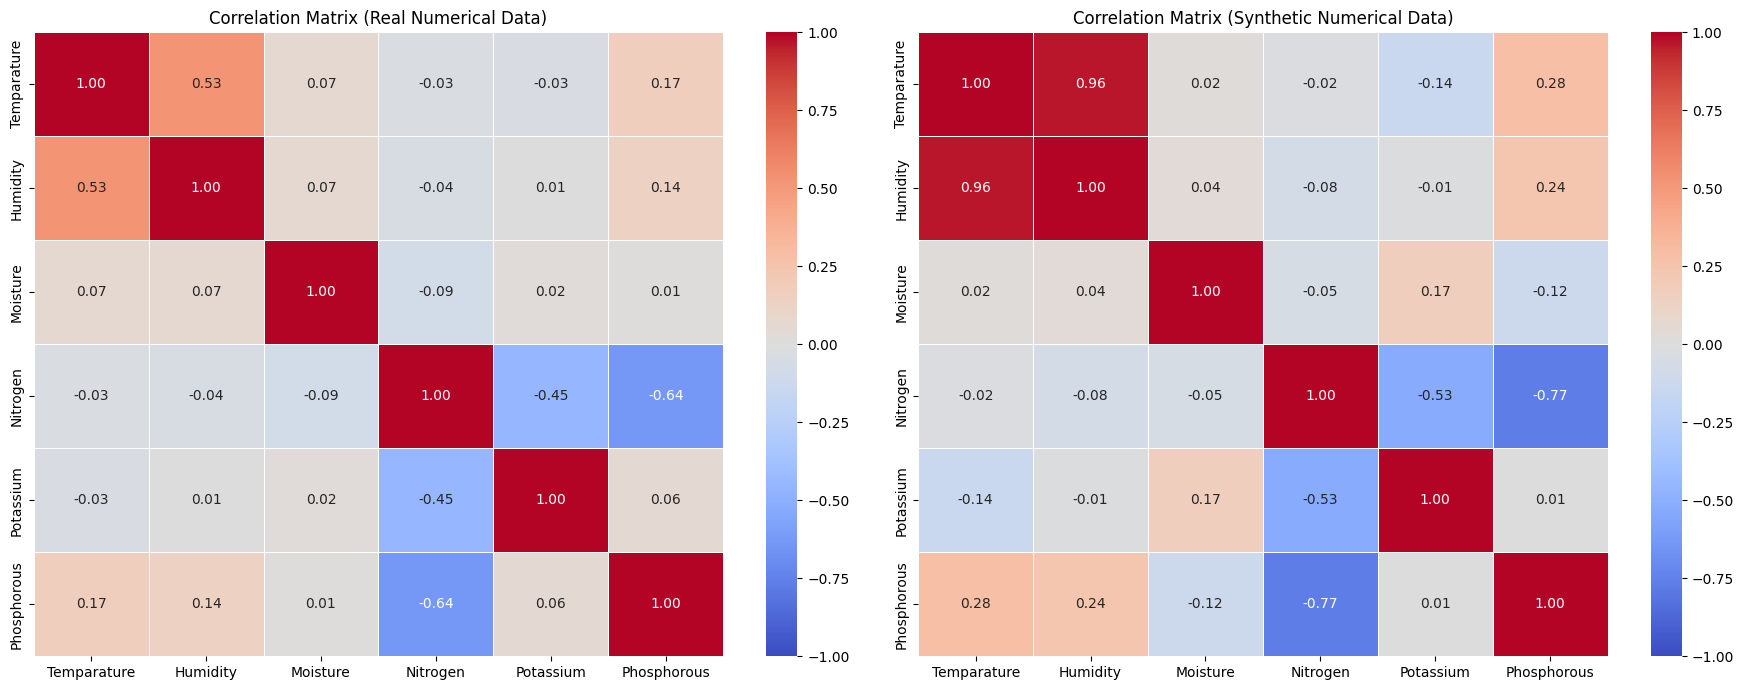

In [50]:
# --- Compare Correlation Matrices ---
print("\n--- Comparing Correlation Matrices (Real vs. Synthetic Numerical) ---")
real_corr_matrix = df_real_numerical.corr()
synth_corr_matrix = df_synthetic_numerical.corr()

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
sns.heatmap(real_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix (Real Numerical Data)')

plt.subplot(1, 2, 2)
sns.heatmap(synth_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix (Synthetic Numerical Data)')

plt.tight_layout()
plt.show()

In [51]:
# --- Kolmogorov-Smirnov Test (Per Numerical Feature) ---
print("\n--- Kolmogorov-Smirnov Test (Real vs. Synthetic Numerical) ---")
ks_results = {}
for col in numerical_features_X:
    real_sample = df_real_numerical[col].dropna().values
    synthetic_sample = df_synthetic_numerical[col].values
    # Ensure samples are not identical (can happen with low variance/clipped data)
    if len(np.unique(real_sample)) > 1 and len(np.unique(synthetic_sample)) > 1:
         ks_stat, p_value = ks_2samp(real_sample, synthetic_sample)
         ks_results[col] = p_value
         print(f"  {col}: p-value = {p_value:.4f}")
    else:
         print(f"  {col}: Skipped (constant data)")
         ks_results[col] = np.nan


--- Kolmogorov-Smirnov Test (Real vs. Synthetic Numerical) ---
  Temparature: p-value = 0.0000
  Humidity: p-value = 0.0000
  Moisture: p-value = 0.0000
  Nitrogen: p-value = 0.0000
  Potassium: p-value = 0.0000
  Phosphorous: p-value = 0.0000


In [52]:
# --- Explainable AI (XAI) using LIME ---
print("\n--- Explainable AI (XAI) for Fertilizer Recommendation (Proxy Task) ---")

# Task: Predict 'Fertilizer Name' using other features.
# We use the *processed* data (X_processed) which includes scaled numerical
# and one-hot encoded Soil Type/Crop Type, as this is what a typical ML model would use.
# Target 'y' is the original Fertilizer Name labels.

# Split data for the XAI proxy classifier
X_train_xai, X_test_xai, y_train_xai, y_test_xai = train_test_split(
    X_processed, y, # Use processed features, original target labels
    test_size=0.3,
    random_state=42,
    stratify=y # Stratify by fertilizer name
)

print(f"XAI Classifier Training samples: {X_train_xai.shape[0]}")
print(f"XAI Classifier Test samples: {X_test_xai.shape[0]}")


--- Explainable AI (XAI) for Fertilizer Recommendation (Proxy Task) ---
XAI Classifier Training samples: 5600
XAI Classifier Test samples: 2400


In [53]:
# Train a RandomForest classifier (often works well and is relatively interpretable)
print("\nTraining RandomForest Classifier for XAI...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_xai, y_train_xai)


Training RandomForest Classifier for XAI...


RandomForestClassifier(class_weight='balanced', random_state=42)

In [54]:
# Evaluate the classifier (optional but good practice)
y_pred_xai = rf_classifier.predict(X_test_xai)
print("\nRandomForest Classifier Performance:")
print(classification_report(y_test_xai, y_pred_xai))


RandomForest Classifier Performance:
              precision    recall  f1-score   support

    10-26-26       0.15      0.15      0.15       339
    14-35-14       0.14      0.16      0.15       356
    17-17-17       0.12      0.11      0.12       337
       20-20       0.14      0.14      0.14       331
       28-28       0.14      0.12      0.13       336
         DAP       0.13      0.13      0.13       350
        Urea       0.13      0.13      0.13       351

    accuracy                           0.14      2400
   macro avg       0.14      0.14      0.14      2400
weighted avg       0.14      0.14      0.14      2400



In [55]:
# Get class names (Fertilizer Names) from the original target 'y'
class_names = sorted(y.unique())

In [56]:
# Identify indices of categorical features *after* one-hot encoding
# Numerical features come first, then OHE features
categorical_indices = list(range(len(numerical_features_X), X_processed.shape[1]))

In [57]:
# Create LIME explainer instance
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_xai,        # Use training data for background distribution
    feature_names=processed_feature_names, # Names after OHE
    class_names=class_names,          # Target class names
    categorical_features=categorical_indices, # Indices of OHE features
    mode='classification',            # We are explaining a classifier
    random_state=42
)


In [58]:
# --- Explain a Specific Instance ---
# Choose an instance from the test set to explain
instance_index = 0 # Explain the first instance in the test set
instance_to_explain = X_test_xai[instance_index]
true_label = y_test_xai.iloc[instance_index]
predicted_label = rf_classifier.predict(instance_to_explain.reshape(1, -1))[0]

print(f"\nExplaining instance #{instance_index}:")
print(f"  True Fertilizer: {true_label}")
print(f"  Predicted Fertilizer: {predicted_label}")


Explaining instance #0:
  True Fertilizer: DAP
  Predicted Fertilizer: Urea


In [59]:

# LIME needs a function that takes data samples and returns prediction probabilities
def rf_predict_proba(data):
    return rf_classifier.predict_proba(data)

# Generate explanation for the chosen instance
# num_features: How many features to show in the explanation
explanation = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=rf_predict_proba,
    num_features=10 # Show top 10 influential features
)

In [60]:
# Show explanation (optional: save to HTML file)
print("\nLIME Explanation:")
# Print textual explanation (feature: weight)
for feature_name, weight in explanation.as_list():
    print(f"  Feature: {feature_name}, Weight: {weight:.4f}")


# Visualize explanation in the notebook (if running in a suitable environment like Colab/Jupyter)
try:
    explanation.show_in_notebook(show_table=True, show_all=False)
    # Or save to HTML
    # explanation.save_to_file(f'lime_explanation_instance_{instance_index}.html')
    # print(f"LIME explanation saved to lime_explanation_instance_{instance_index}.html")
except Exception as e:
     print(f"\nCould not display LIME plot in notebook: {e}")
     print("Textual explanation provided above.")


LIME Explanation:
  Feature: Crop Type_Cotton=0, Weight: -0.0188
  Feature: Crop Type_Millets=0, Weight: 0.0096
  Feature: Crop Type_Maize=0, Weight: 0.0094
  Feature: Soil Type_Clayey=0, Weight: -0.0083
  Feature: Crop Type_Sugarcane=0, Weight: 0.0081
  Feature: Soil Type_Black=1, Weight: 0.0053
  Feature: Moisture <= -0.77, Weight: -0.0049
  Feature: Crop Type_Pulses=0, Weight: -0.0049
  Feature: -0.37 < Nitrogen <= 0.64, Weight: 0.0049
  Feature: -0.79 < Phosphorous <= -0.04, Weight: 0.0049


In [61]:
# --- Explain another instance (Example) ---
instance_index = 5
instance_to_explain = X_test_xai[instance_index]
true_label = y_test_xai.iloc[instance_index]
predicted_label = rf_classifier.predict(instance_to_explain.reshape(1, -1))[0]
print(f"\nExplaining instance #{instance_index}:")
print(f"  True Fertilizer: {true_label}")
print(f"  Predicted Fertilizer: {predicted_label}")

explanation_2 = explainer.explain_instance(instance_to_explain, rf_predict_proba, num_features=10)
print("\nLIME Explanation 2:")

# ------- FIX HERE: don't index processed_feature_names -------
for feature_name, weight in explanation_2.as_list():
    print(f"  Feature: {feature_name}, Weight: {weight:.4f}")
# --------------------------------------------------------------

try:
    explanation_2.show_in_notebook(show_table=True, show_all=False)
except Exception as e:
     print(f"\nCould not display LIME plot in notebook: {e}")
     print("Textual explanation provided above.")

print("\n--- Project Analysis Completed ---")



Explaining instance #5:
  True Fertilizer: 10-26-26
  Predicted Fertilizer: Urea

LIME Explanation 2:
  Feature: Crop Type_Cotton=0, Weight: -0.0133
  Feature: Soil Type_Clayey=0, Weight: -0.0104
  Feature: Crop Type_Millets=0, Weight: 0.0093
  Feature: Crop Type_Maize=0, Weight: 0.0074
  Feature: Crop Type_Barley=0, Weight: 0.0071
  Feature: -0.01 < Humidity <= 0.72, Weight: 0.0070
  Feature: Soil Type_Black=0, Weight: -0.0069
  Feature: Crop Type_Tobacco=0, Weight: -0.0065
  Feature: Soil Type_Red=1, Weight: -0.0064
  Feature: Crop Type_Paddy=1, Weight: -0.0056



--- Project Analysis Completed ---


In [62]:
import joblib
import tensorflow as tf
import os


In [63]:
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)


In [64]:
cvae_weights_path = os.path.join(output_dir, 'cvae_weights.weights.h5') # Use .weights.h5 extension
cvae.save_weights(cvae_weights_path)
print(f"CVAE weights saved to {cvae_weights_path}")

CVAE weights saved to /kaggle/working/cvae_weights.weights.h5


In [65]:
# --- Save the RandomForest Classifier ---
# Assuming your trained RF model is 'rf_classifier'
rf_path = os.path.join(output_dir, 'rf_classifier.joblib')
joblib.dump(rf_classifier, rf_path)
print(f"RandomForest model saved to {rf_path}")


RandomForest model saved to /kaggle/working/rf_classifier.joblib


In [66]:
preprocessor_path = os.path.join(output_dir, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to {preprocessor_path}")

Preprocessor saved to /kaggle/working/preprocessor.joblib


In [67]:
fertilizer_ohe_path = os.path.join(output_dir, 'fertilizer_ohe.joblib')
joblib.dump(fertilizer_ohe, fertilizer_ohe_path)
print(f"Fertilizer OHE saved to {fertilizer_ohe_path}")

Fertilizer OHE saved to /kaggle/working/fertilizer_ohe.joblib
